1. Load Nasdaq stocks twitter sentiment data with courtesy from Luke Hardy. 

https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/tree/main

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os

plt.style.use('ggplot')

data_folder = 'C:/Users/keith/anaconda3/Keith Python/final capstone repo'

sen_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sen_df['date'] = pd.to_datetime(sen_df['date'])
sen_df = sen_df.set_index(['date','symbol'])

sen_df['engagement_ratio'] = sen_df['twitterComments']/sen_df['twitterLikes']
sen_df  = sen_df[(sen_df['twitterComments']>10) & (sen_df['twitterLikes']>20)]

sen_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

2. Aggregate monthly and calculate average sentiment for the month

In [2]:
aggregate_df = (sen_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                                             [['engagement_ratio']].mean())
aggregate_df['rank'] = aggregate_df.groupby(level=0)['engagement_ratio']\
                                            .transform(lambda x: x.rank(ascending=False))

aggregate_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

3. Select top 5 stocks based on their cross sectional ranking for each month.

In [3]:
filtered_df = aggregate_df[aggregate_df['rank']<=10].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date','symbol'])
filtered_df.head(10)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           BA              0.421166   8.0
           DAL             0.618896   6.0
           FCX             0.626323   5.0
           GS              0.376872  10.0
           J               0.454916   7.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           REGN            0.415747   9.0
           SLB             0.647374   4.0

4. Extract the stocks to form a portfolio with at the start of each new month

In [4]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
# fixed_dates

5. Download fresh stock prices for only selected stocks

In [5]:
start = (pd.to_datetime(list(fixed_dates.keys())[0]) - pd.DateOffset(years=1) + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
end = (pd.to_datetime(list(fixed_dates.keys())[-1]) + pd.DateOffset(months=1)).strftime('%Y-%m-%d')

stocks_list = sen_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start= start,#'2021-01-01',
                        end=end)#'2023-03-01')

prices_df 

[*********************100%%**********************]  85 of 85 completed


1 Failed download:
['ATVI']: Exception('%ticker%: No timezone found, symbol may be delisted')


Adj Close                                                         \
                     A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  116.384758  15.13  146.445511  127.164169   93.054260  103.603287   
2021-01-05  117.336304  15.43  146.287277  128.736389   94.016510  104.885155   
2021-01-06  120.553947  15.52  154.738571  124.402916   93.204338  104.666763   
2021-01-07  123.761795  15.38  156.060226  128.647964   94.201904  105.682770   
2021-01-08  124.644684  15.13  158.284729  129.758331   94.696243  105.977104   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  141.055115  15.56  140.654022  148.308395  146.196243  101.131828   
2023-02-23  142.167023  15.87  139.077255  148.796417  147.554688  100.993942   
2023-02-24  140.181458  15.56  135.982544  146.117294  148.175690   98.935654   
2023-02-27  141.154388  15.63  137.725784  147.322372  149.699051   98.256119   
2023-02-28  140.945892  15.98  141.966354  146.814438  149.330338  100.176537   

                                                         ...   Volume  \
                  AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  73.126450  21.361834  149.119400  92.300003  ...  5732800   
2021-01-05  73.027802  22.078794  159.182480  92.769997  ...  4029500   
2021-01-06  73.610741  22.961214  171.072540  90.330002  ...  3612500   
2021-01-07  71.646706  22.731419  179.767853  95.160004  ...  3993700   
2021-01-08  71.009972  23.365654  179.865555  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  88.074539  24.740526  244.324448  76.610001  ...  2044600   
2023-02-23  87.967865  24.740526  251.660629  79.750000  ...  2066600   
2023-02-24  87.696335  24.672318  247.367966  78.089996  ...  2875100   
2023-02-27  87.347214  24.243570  254.803284  78.769997  ...  2459700   
2023-02-28  85.310699  24.048691  252.116653  78.580002  ...  3662300   

                                                                               \
               REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

                                
                   V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

6. Calculate portfolio return with monthly rebalancing

In [6]:
returns_df = np.log(prices_df['Adj Close']).diff().iloc[1:-1,:]

returns_df.index = pd.to_datetime(returns_df.index)


portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[pd.to_datetime(start_date):end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
# portfolio_df.head(10)

7. Download Nasdaq (QQQ) prices and calculate returns to compare against our strategy

In [7]:
qqq_df = yf.download(tickers='QQQ',
                    start = start,
                    end = end)

qqq_return = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_return,
                                 left_index=True,
                                 right_index=True)

portfolio_df.head(10)

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.025165,-0.017159
2021-12-02,0.034325,0.007181
2021-12-03,-0.008779,-0.017542
2021-12-06,0.021157,0.007981
2021-12-07,0.022291,0.029669
2021-12-08,0.006737,0.004464
2021-12-09,-0.008531,-0.014824
2021-12-10,0.001593,0.010812
2021-12-13,-0.024866,-0.014552


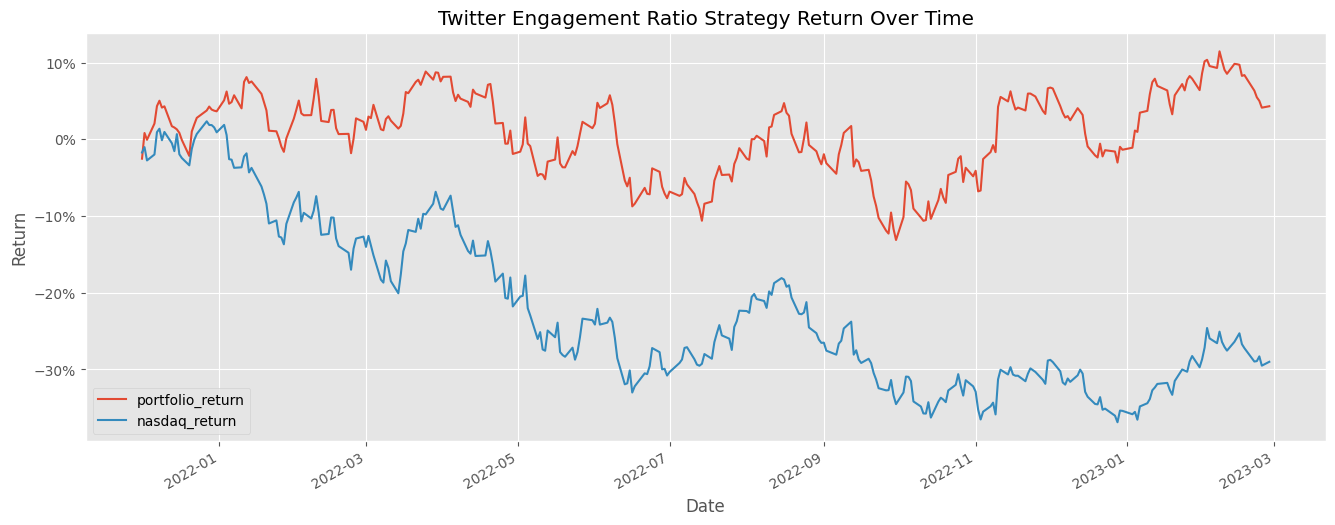

In [8]:
import matplotlib.ticker as mtick

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()